## TensorFlow 輸出 ONNX 並使用 ONNX Runtime 運行
在本範例中，我們將訓練好的 iris DNN 分類模型輸出成 ONNX 格式，並在 Python ONNX Runtime 中執行推論。ONNX Runtime 是高效能的推斷引擎，可將 ONNX 模型部署到生產環境，可在多個平台(Windows、Linux、Mac)和硬體(CPU 和 GPU)高效地進行推理。ONNX 擺脫原本神經網路框架，並使用 ONNX Runtime 可大大提高多個模型的性能。

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# 設定亂數種子數值
seed_value= 4
# 1. 設定 Python 環境變數亂數種子
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. 設定 Python 內建亂數生成器亂數種子
import random
random.seed(seed_value)
# 3. 設定 Numpy 亂數種子
import numpy as np
np.random.seed(seed_value)
# 4. 設定 TensorFlow 亂數種子
import tensorflow as tf
tf.random.set_seed(seed_value)

## 1) 載入資料集

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
X, y = iris.data, iris.target

print('X 資料: ',X.shape)
print('y 資料: ',y.shape)

X 資料:  (150, 4)
y 資料:  (150,)


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

In [4]:
X[0]

array([5.1, 3.5, 1.4, 0.2])

## 2) 將輸出特徵做one-hot encoding
class 的值有 0,1,2

In [5]:
from tensorflow.keras.utils import to_categorical
y_categorical = to_categorical(y)
y_categorical[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## 3) 切割訓練集與測試集

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.25 , random_state=40)

print('訓練資料: ',X_train.shape)
print('測試資料: ',X_test.shape)

訓練資料:  (112, 4)
測試資料:  (38, 4)


## 4) 建立網路模型

In [157]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.3.1


In [158]:
# 此範例使用 Tensorflow2.0 Sequential API 搭建神經網路。
tf.keras.backend.clear_session() # 清空網路暫存
model = Sequential()
model.add(Dense(128, Activation('relu'), input_dim=X.shape[-1], name='tensor'))
model.add(Dense(256, Activation('relu'), name='dense_1'))
model.add(Dense(3, Activation('softmax'), name='tensor_output'))

In [161]:
# 此範例使用 Tensorflow2.0 Sequential API 搭建神經網路。
tf.keras.backend.clear_session() # 清空網路暫存
model = Sequential()
model.add(Dense(8, Activation('relu'), input_dim=X.shape[-1], name='tensor'))
model.add(Dense(16, Activation('relu'), name='dense_1'))
model.add(Dense(32, Activation('relu'), name='dense_2'))
model.add(Dense(64, Activation('relu'), name='dense_3'))
model.add(Dense(128, Activation('relu'), name='dense_4'))
model.add(Dense(1024, Activation('relu'), name='dense_5'))
model.add(Dense(3, Activation('softmax'), name='tensor_output'))

In [162]:
model.summary()   # Weights = (4+1)*8+(8+1)*16+(16+1)*3 = 235

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (Dense)               (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              132096    
_________________________________________________________________
tensor_output (Dense)        (None, 3)                 3

In [100]:
# 編譯模型
optim = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

batch_size=1
epochs = 20

# 訓練模型
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.1)


Epoch 1/20
100/100 [==============================] - 0s 2ms/step - loss: 1.0334 - acc: 0.3700 - val_loss: 1.0195 - val_acc: 0.0833
Epoch 2/20
100/100 [==============================] - 0s 721us/step - loss: 0.8093 - acc: 0.6700 - val_loss: 0.7585 - val_acc: 0.4167
Epoch 3/20
100/100 [==============================] - 0s 707us/step - loss: 0.5486 - acc: 0.7200 - val_loss: 0.5799 - val_acc: 0.5000
Epoch 4/20
100/100 [==============================] - 0s 762us/step - loss: 0.4033 - acc: 0.8600 - val_loss: 0.5994 - val_acc: 0.4167
Epoch 5/20
100/100 [==============================] - 0s 741us/step - loss: 0.3492 - acc: 0.8600 - val_loss: 0.4232 - val_acc: 0.6667
Epoch 6/20
100/100 [==============================] - 0s 759us/step - loss: 0.2739 - acc: 0.9300 - val_loss: 0.3481 - val_acc: 0.7500
Epoch 7/20
100/100 [==============================] - 0s 733us/step - loss: 0.2599 - acc: 0.9200 - val_loss: 0.2173 - val_acc: 0.9167
Epoch 8/20
100/100 [==============================] - 0s 761us/s

## 6) 觀察訓練結果

In [101]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs_ = range(1,len(acc)+1)

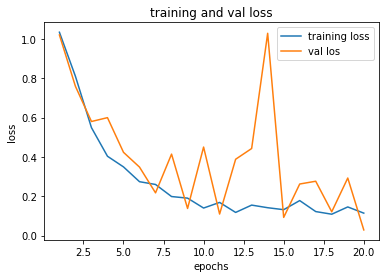

In [102]:
plt.plot(epochs_ , loss , label = 'training loss')
plt.plot(epochs_ , val_loss , label = 'val los')
plt.title('training and val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

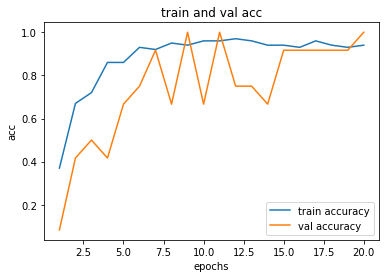

In [103]:
plt.clf()
plt.plot(epochs_ , acc , label='train accuracy')
plt.plot(epochs_ , val_acc , label = 'val accuracy')
plt.title('train and val acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

## 7) 測試集測試

In [104]:
from sklearn.metrics import accuracy_score

label=np.argmax(y_test,axis=1)
pred =  np.argmax(model.predict(X_test), axis=1)
print(accuracy_score(label, pred))

0.9473684210526315


## 8) 輸出 ONNX

In [105]:
import tf2onnx
import onnx
# input_signature = [tf.TensorSpec([6.7, 3.1, 4.4, 1.4], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "./model/tf_model(1323).onnx")

## Python ONNX Runtime 進行推論

In [106]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt

sess = rt.InferenceSession("./model/tf_model(1323).onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: [[6.7, 3.1, 4.4, 1.4]]})[0]
print(pred_onx.argmax(axis=1))

[1]


In [107]:
pred_onx = sess.run([label_name], {input_name: [[6.4, 3.2, 5.3, 2.3]]})[0]
print(pred_onx.argmax(axis=1))

[2]


![](https://i.imgur.com/Xvgrzmy.png)

https://tmrmds.co/article-business/18290/?fbclid=IwAR3YzL3-GLjrZ_byFZ3ac43M1ttY01HC_SAjN84JtvoNUZQifTFqIIYBISk

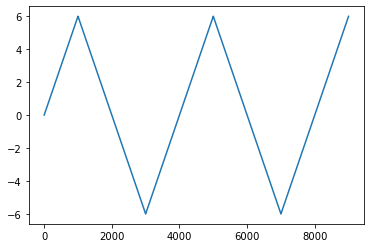

In [9]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 9000, 1)
y = 4*a/p * abs((((x-p/4)%p)+p)%p - p/2) - a ;
plt.plot(x,y)